In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from netgraph import Graph

In [2]:
df_summary = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_disruptions_summary.txt', sep = ' ', engine='python')
df_summary.head(10)

#DISRUP_ID             LAYER        STATION_A          STATION_B  \
0      DISR1      metropolitan          aldgate        bakerstreet   
1      DISR2  hammersmith&city          barking           moorgate   
2      DISR3               dlr          beckton        canningtown   
3      DISR4        overground  claphamjunction        surreyquays   
4      DISR5        overground         richmond  willesdenjunction   
5      DISR6          northern          edgware          hampstead   
6      DISR7        piccadilly        actontown           uxbridge   
7      DISR8        overground  claphamjunction  willesdenjunction   
8      DISR9        piccadilly      raynerslane           uxbridge   
9     DISR10        overground         newcross        westcroydon   

   FREQUENCY%  DAMAGED_NODES%  
0      3.3457           2.439  
1      2.8914           3.523  
2      2.5609           2.439  
3      2.0240           1.897  
4      1.9413           1.626  
5      1.8174           1.897  
6      1.5696           4.065  
7      1.5696           1.626  
8      1.5283           1.897  
9      1.4457           2.981

In [3]:
layers = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_layers.txt', sep = ' ', engine='python')
layers.head(10)

layerID   layerLabel
1 Tube       (All underground   lines  aggregated)
2 Overground NaN  NaN            None         None
3 DLR        NaN  NaN            None         None

In [20]:
nodes_df = pd.read_csv('../References/London_Multiplex_Transport/Dataset/london_transport_nodes.txt', sep = ' ', engine='python')
nodes_df.head(10)

nodeID          nodeLabel    nodeLat  nodeLong
0       0          abbeyroad  51.531952  0.003738
1       1            westham  51.528526  0.005332
2       2       actoncentral  51.508758 -0.263416
3       3  willesdenjunction  51.532234 -0.243895
4       4          actontown  51.503071 -0.280288
5       5       chiswickpark  51.494371 -0.267723
6       6       turnhamgreen  51.495182 -0.254510
7       7            aldgate  51.514342 -0.075613
8       8    liverpoolstreet  51.517598 -0.082235
9       9        aldgateeast  51.515082 -0.072987

In [17]:
edges_file = '../References/London_Multiplex_Transport/Dataset/london_transport_raw.edges'
edges_df = pd.read_csv(edges_file, sep=' ', names=['Line', 'From Station', 'To Station'])


In [18]:
edges_df.head()

Line       From Station       To Station
0  bakerloo  harrow&wealdstone           kenton
1  bakerloo             kenton      southkenton
2  bakerloo        southkenton     northwembley
3  bakerloo       northwembley   wembleycentral
4  bakerloo     wembleycentral  stonebridgepark

In [29]:
edges_df["Line"].unique()

array(['bakerloo', 'central', 'circle', 'district', 'hammersmith&city',
       'jubilee', 'metropolitan', 'northern', 'piccadilly', 'victoria',
       'waterloo&city', 'overground', 'dlr'], dtype=object)

In [5]:
df_summary['LAYER'].unique()

array(['metropolitan', 'hammersmith&city', 'dlr', 'overground',
       'northern', 'piccadilly', 'jubilee', 'district', 'victoria',
       'bakerloo', 'circle'], dtype=object)

In [61]:
G = nx.Graph()


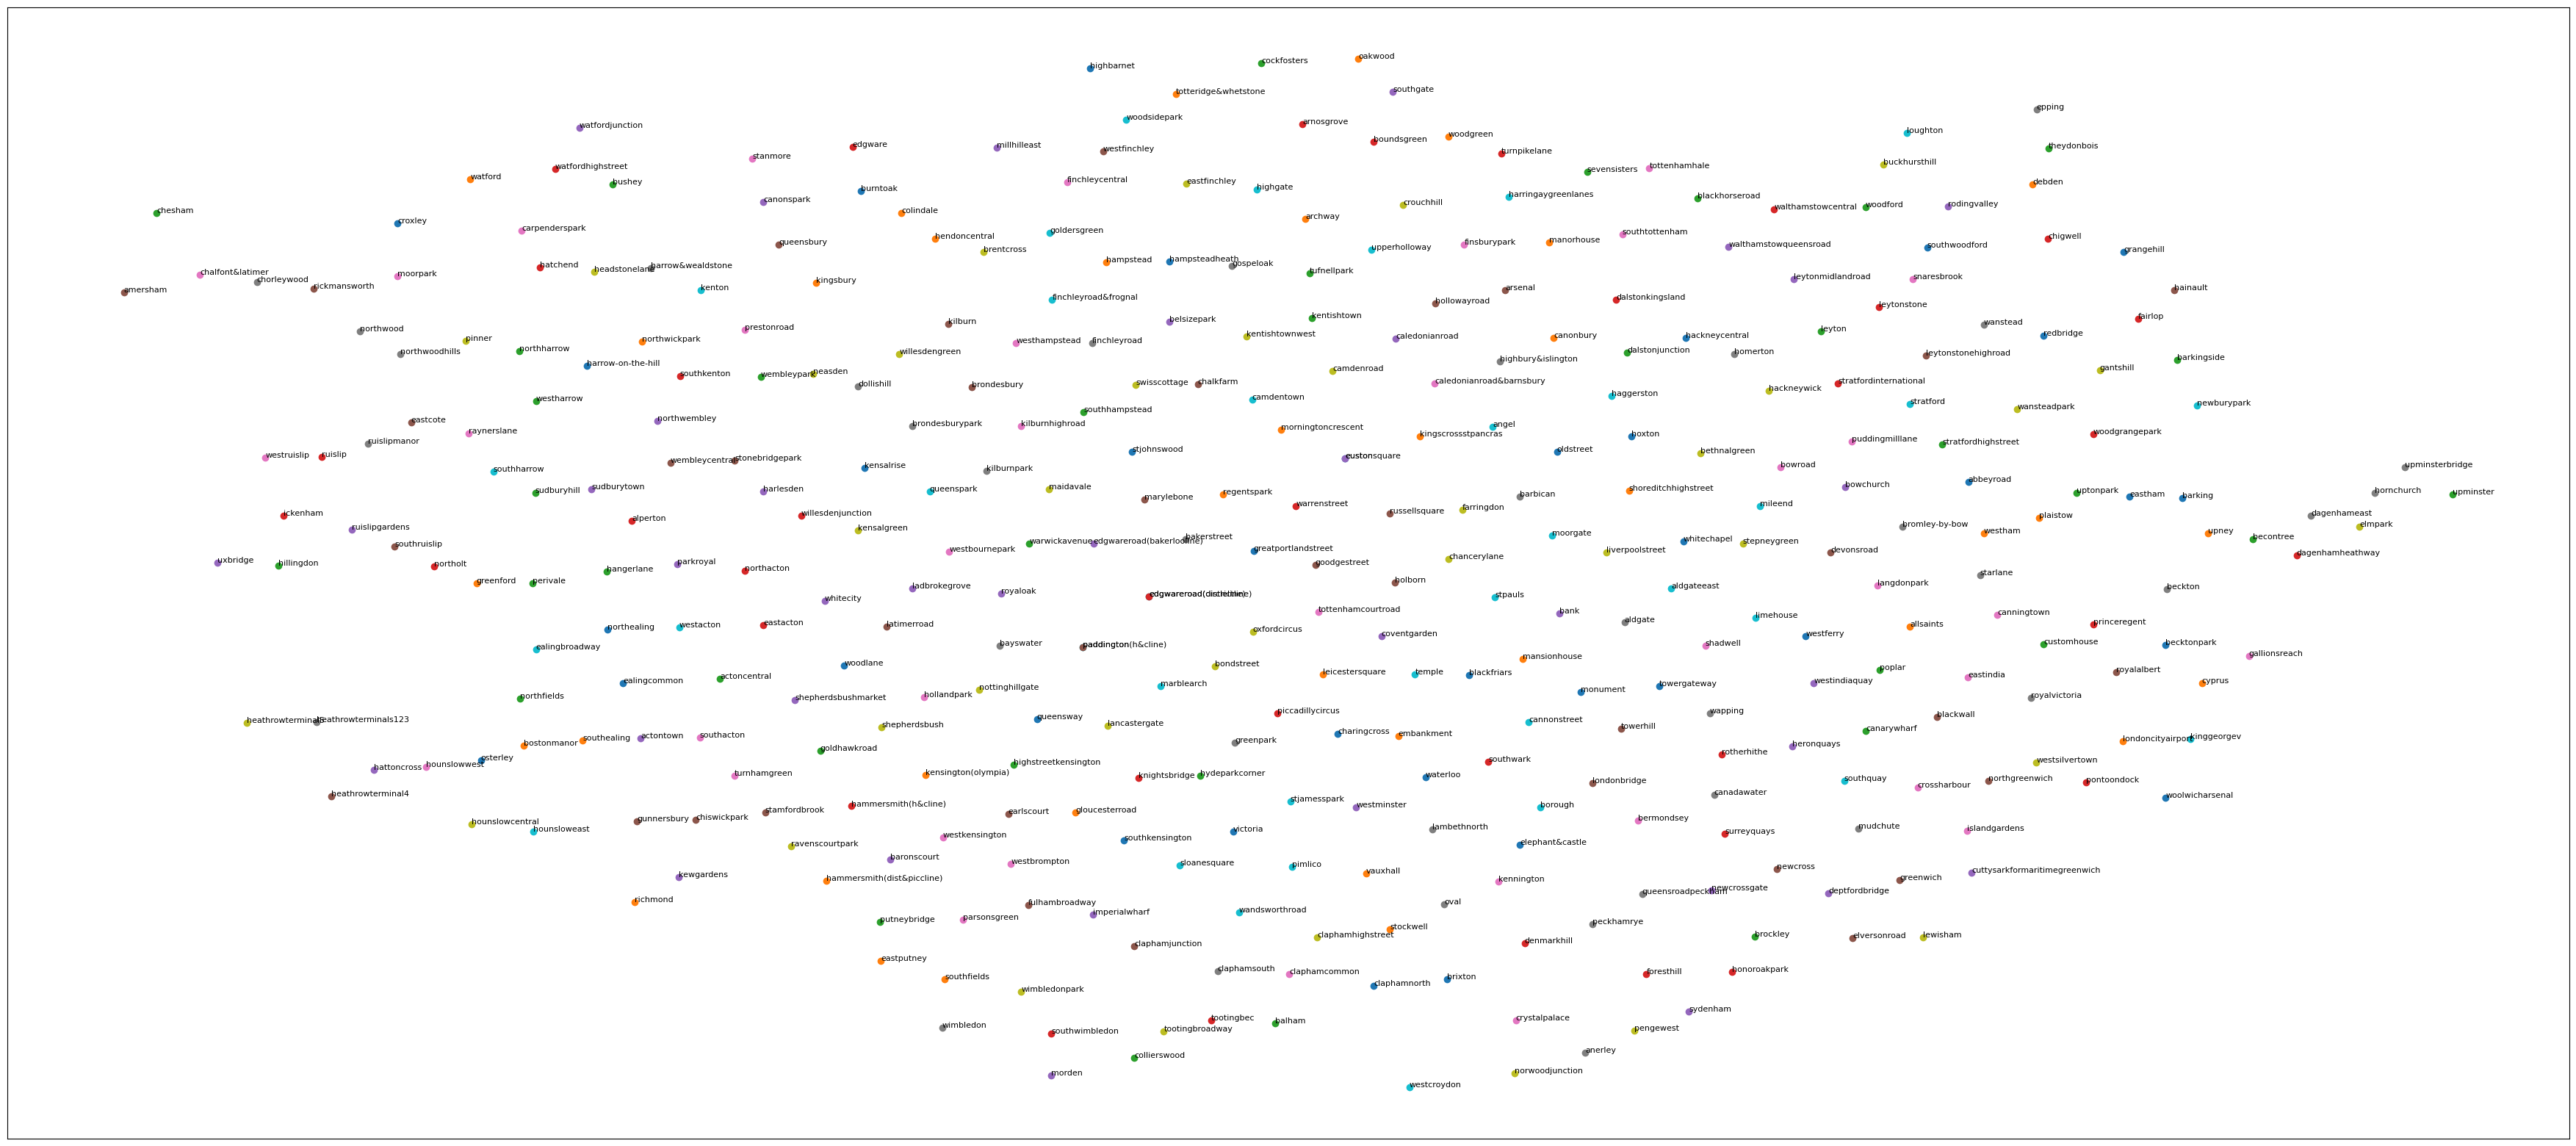

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

def apply_repulsion(cartesian_df, iterations=100, repulsion_strength=0.01):
    """
    Apply a simple repulsion force to spread out nodes to avoid overlapping.
    
    Parameters:
    - cartesian_df (pd.DataFrame): DataFrame with Cartesian coordinates.
    - iterations (int): Number of iterations for the force-directed algorithm.
    - repulsion_strength (float): Strength of the repulsion force.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with adjusted Cartesian coordinates.
    """
    coords = cartesian_df[['x', 'y']].values
    for _ in range(iterations):
        distances = squareform(pdist(coords))
        # Avoid division by zero and ensure valid distances
        np.fill_diagonal(distances, np.inf)
        with np.errstate(divide='ignore', invalid='ignore'):
            repulsion = np.nan_to_num(repulsion_strength / distances**2, nan=0.0, posinf=0.0, neginf=0.0)
        force_x = np.sum(repulsion * (coords[:, 0][:, np.newaxis] - coords[:, 0]), axis=1)
        force_y = np.sum(repulsion * (coords[:, 1][:, np.newaxis] - coords[:, 1]), axis=1)
        coords[:, 0] += force_x
        coords[:, 1] += force_y
    
    cartesian_df['x'] = coords[:, 0]
    cartesian_df['y'] = coords[:, 1]
    return cartesian_df

def convert_to_cartesian(nodes_df, figsize=(45, 20), iterations=100, repulsion_strength=0.01):
    """
    Convert latitude and longitude to Cartesian coordinates for plotting.
    
    Parameters:
    - nodes_df (pd.DataFrame): DataFrame with columns ['nodeID', 'nodeLabel', 'nodeLat', 'nodeLong'].
    - figsize (tuple): Size of the figure for plotting.
    - iterations (int): Number of iterations for the force-directed algorithm.
    - repulsion_strength (float): Strength of the repulsion force.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['nodeID', 'nodeLabel', 'x', 'y'] for Cartesian coordinates.
    """
    # Ensure there are no NaN values in latitude and longitude
    nodes_df = nodes_df.dropna(subset=['nodeLat', 'nodeLong'])
    
    # Extract latitudes and longitudes
    latitudes = nodes_df['nodeLat'].values
    longitudes = nodes_df['nodeLong'].values
    
    # Normalize latitudes and longitudes to range [0, 1]
    scaler = MinMaxScaler()
    normalized_coords = scaler.fit_transform(np.column_stack((latitudes, longitudes)))
    
    # Scale to the size of the figure
    fig_width, fig_height = figsize
    scaled_lats = normalized_coords[:, 0] * fig_height
    scaled_longs = normalized_coords[:, 1] * fig_width
    
    # Create a DataFrame with Cartesian coordinates
    cartesian_df = pd.DataFrame({
        'nodeID': nodes_df['nodeID'],
        'nodeLabel': nodes_df['nodeLabel'],
        'x': scaled_longs,
        'y': scaled_lats
    })
    
    # Apply repulsion to spread out nodes
    cartesian_df = apply_repulsion(cartesian_df, iterations, repulsion_strength)
    
    return cartesian_df


cartesian_df = convert_to_cartesian(nodes_df)

# print(cartesian_df)

# Plotting
plt.figure(figsize=(45, 20))
for _, row in cartesian_df.iterrows():
    plt.scatter(row['x'], row['y'], label=row['nodeLabel'])
    plt.text(row['x'], row['y'], row['nodeLabel'], fontsize=8)
plt.xticks([])  # Remove x-axis labels
plt.yticks([]) 
plt.show()

In [78]:
line_colors = {
    'bakerloo': 'brown',
    'circle': 'yellow',
    'district': 'green',
    'hammersmith&city': 'pink',
    'jubilee': 'gray',
    'metropolitan': 'purple',
    'northern': 'black',
    'piccadilly': 'blue',
    'victoria': 'cyan',
    'waterloo&city': 'lightblue',
    'overground': 'orange',
    'dlr': 'lightgreen',
    'central': 'red'  # Adding Central line for completeness
}

In [79]:
# creating a dictionary to store stations for each line
line_stations = {}
for line in line_colors:
    line_stations[line] = set(edges_df[edges_df['Line'] == line]['From Station']).union(set(edges_df[edges_df['Line'] == line]['To Station']))

In [80]:

# G = nx.Graph()

# Add nodes with labels and color attributes
node_color_map = {}
for line, stations in line_stations.items():
    for station in stations:
        G.add_node(station)
        node_color_map[station] = line_colors[line]

# Add edges and set edge colors
for _, row in edges_df.iterrows():
    line = row['Line']
    if row['From Station'] in line_stations[line] and row['To Station'] in line_stations[line]:
        G.add_edge(row['From Station'], row['To Station'], color=line_colors[line])
    else:
        G.add_edge(row['From Station'], row['To Station'], color='gray')

# Get edge colors
edge_colors = [G[u][v]['color'] for u, v in G.edges()]

# Get node colors
node_colors = [node_color_map[node] if node in node_color_map else 'skyblue' for node in G.nodes()]

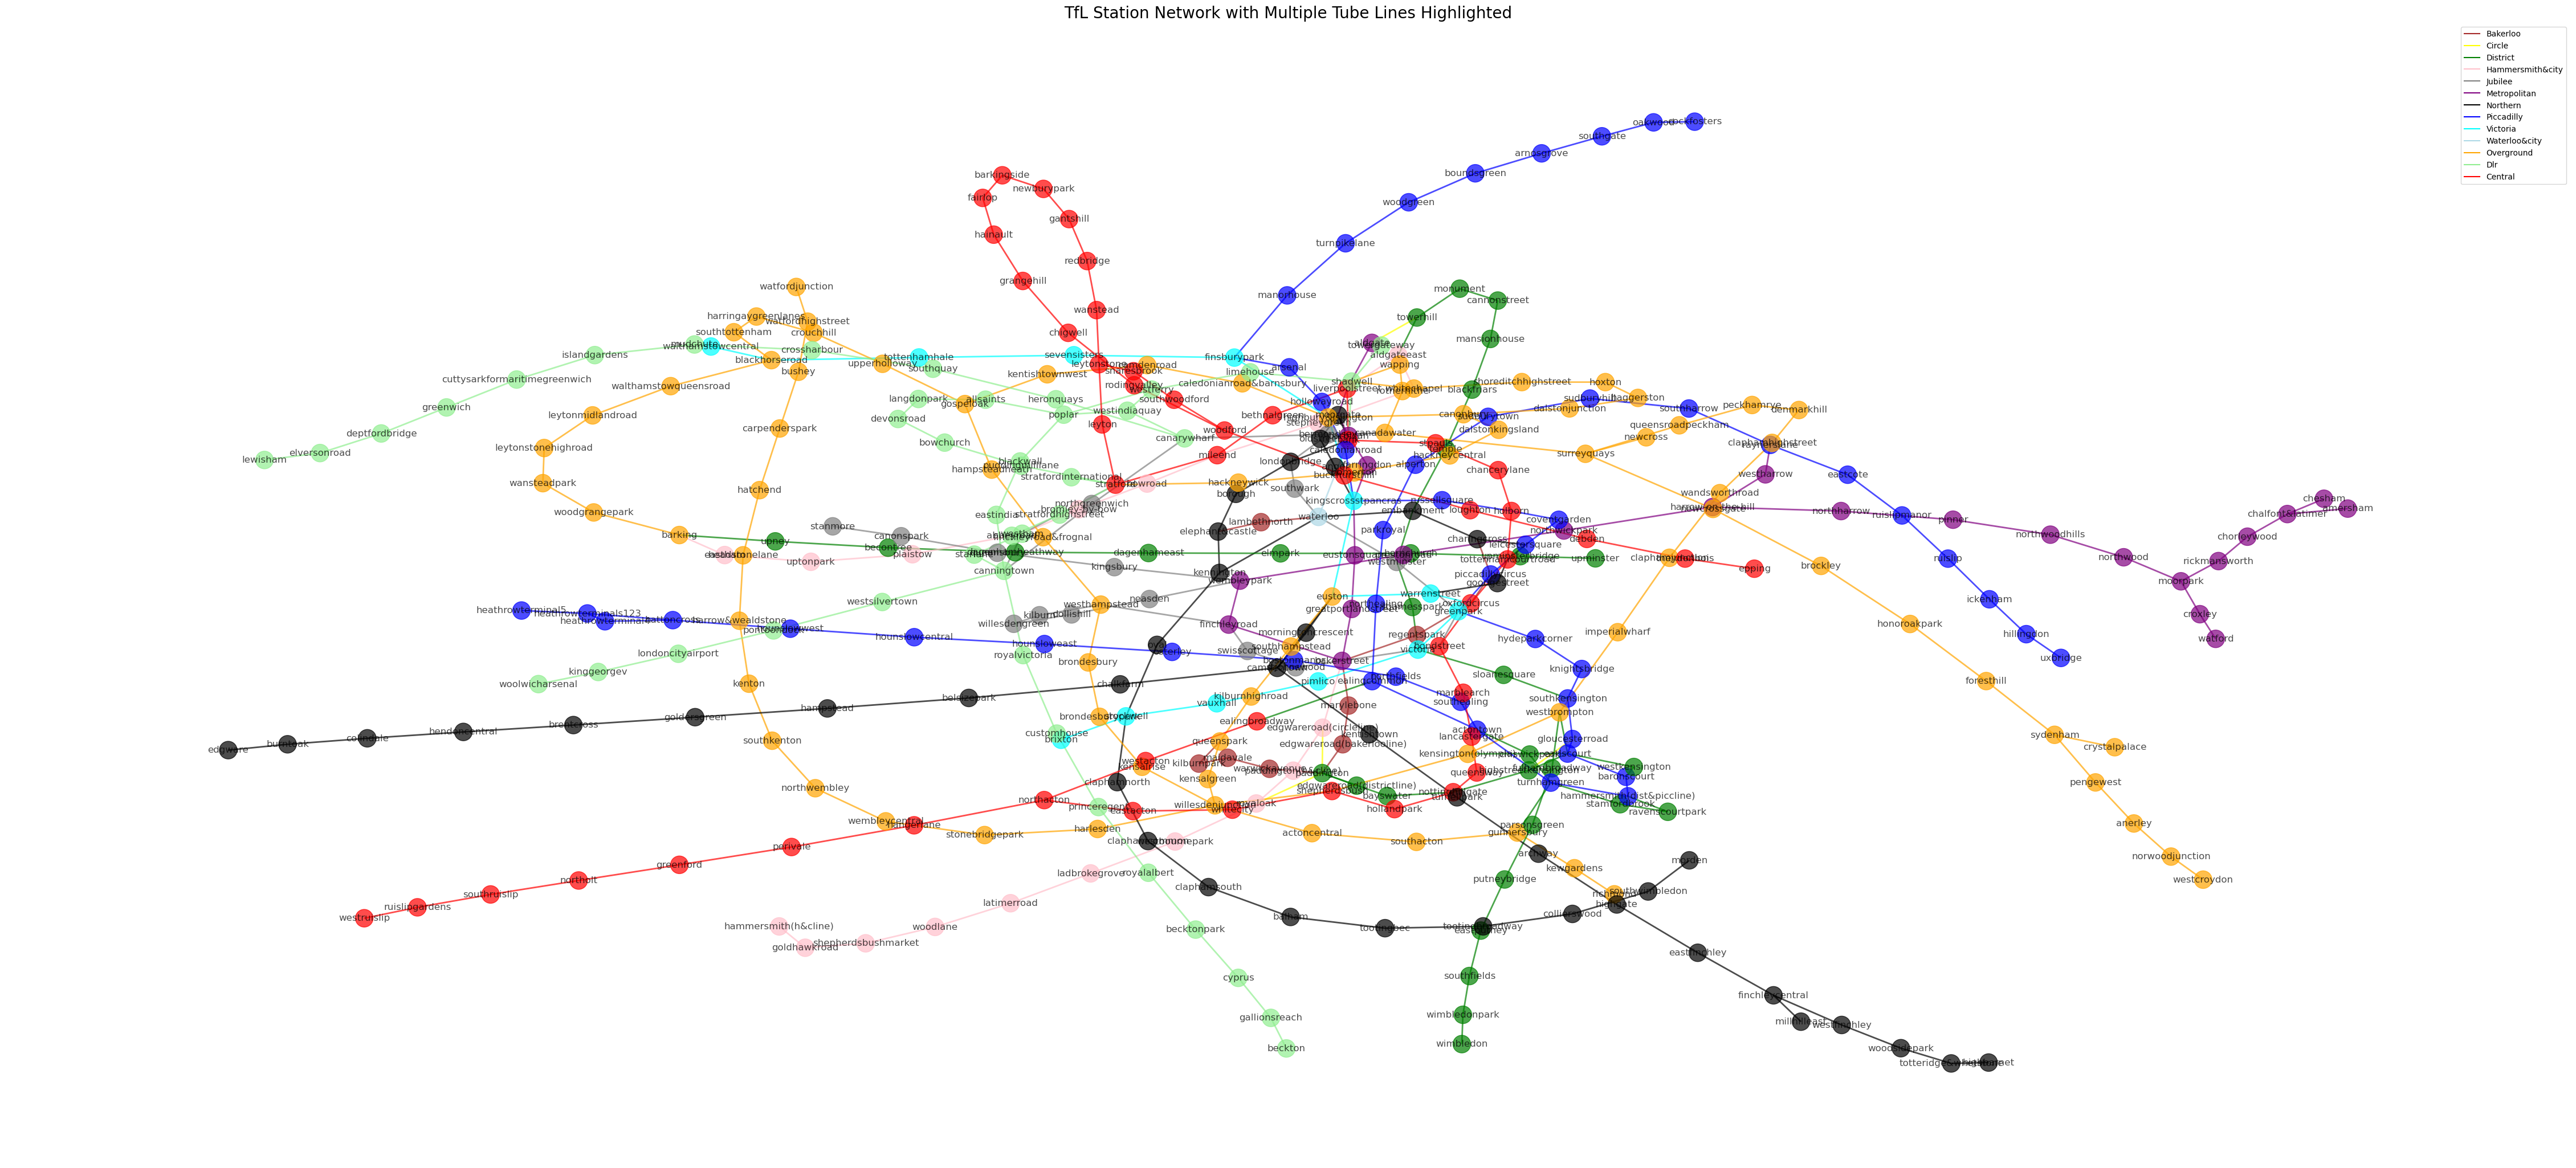

In [81]:
# Plot the graph
plt.figure(figsize=(45, 20))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes using a spring layout
nx.draw(G, pos, with_labels=True, node_size=500, font_size=12, node_color=node_colors, font_color='black', edge_color=edge_colors, width=2, alpha=0.7)

# Create custom legend for line colors
legend_patches = []
for line, color in line_colors.items():
    legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))

plt.legend(handles=legend_patches)

plt.title('TfL Station Network with Multiple Tube Lines Highlighted', fontsize=20)
plt.show()

In [68]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Find top node for each centrality measure
top_degree = max(degree_centrality, key=degree_centrality.get)
top_betweenness = max(betweenness_centrality, key=betweenness_centrality.get)
top_closeness = max(closeness_centrality, key=closeness_centrality.get)

# Print top nodes for each centrality measure
print(f"Top Degree Centrality: {top_degree}, Value: {degree_centrality[top_degree]}")
print(f"Top Betweenness Centrality: {top_betweenness}, Value: {betweenness_centrality[top_betweenness]}")
print(f"Top Closeness Centrality: {top_closeness}, Value: {closeness_centrality[top_closeness]}")

Top Degree Centrality: bakerstreet, Value: 0.019021739130434784
Top Betweenness Centrality: bank, Value: 0.23987714098482923
Top Closeness Centrality: greenpark, Value: 0.11295273173726213


Top 5 nodes by Degree Centrality: [('bakerstreet', 0.019021739130434784), ('kingscrossstpancras', 0.019021739130434784), ('stratford', 0.019021739130434784), ('oxfordcircus', 0.016304347826086956), ('waterloo', 0.016304347826086956)]
Top 5 nodes by Betweenness Centrality: [('bank', 0.23987714098482923), ('waterloo', 0.2254827592539357), ('kingscrossstpancras', 0.22335320232525857), ('greenpark', 0.21981973398200744), ('bakerstreet', 0.21915043621261734)]
Top 5 nodes by Closeness Centrality: [('greenpark', 0.11295273173726213), ('westminster', 0.11004784688995216), ('bondstreet', 0.10994920824619062), ('kingscrossstpancras', 0.10988354732756046), ('oxfordcircus', 0.10952380952380952)]
Top 5 nodes by Eigenvector Centrality: [('oxfordcircus', 0.3968157978956346), ('greenpark', 0.39036243116617064), ('piccadillycircus', 0.30975629560797274), ('bondstreet', 0.2835513647087155), ('westminster', 0.22314485167327802)]
Top 5 nodes by PageRank: [('stratford', 0.006848834476307878), ('kingscrosss

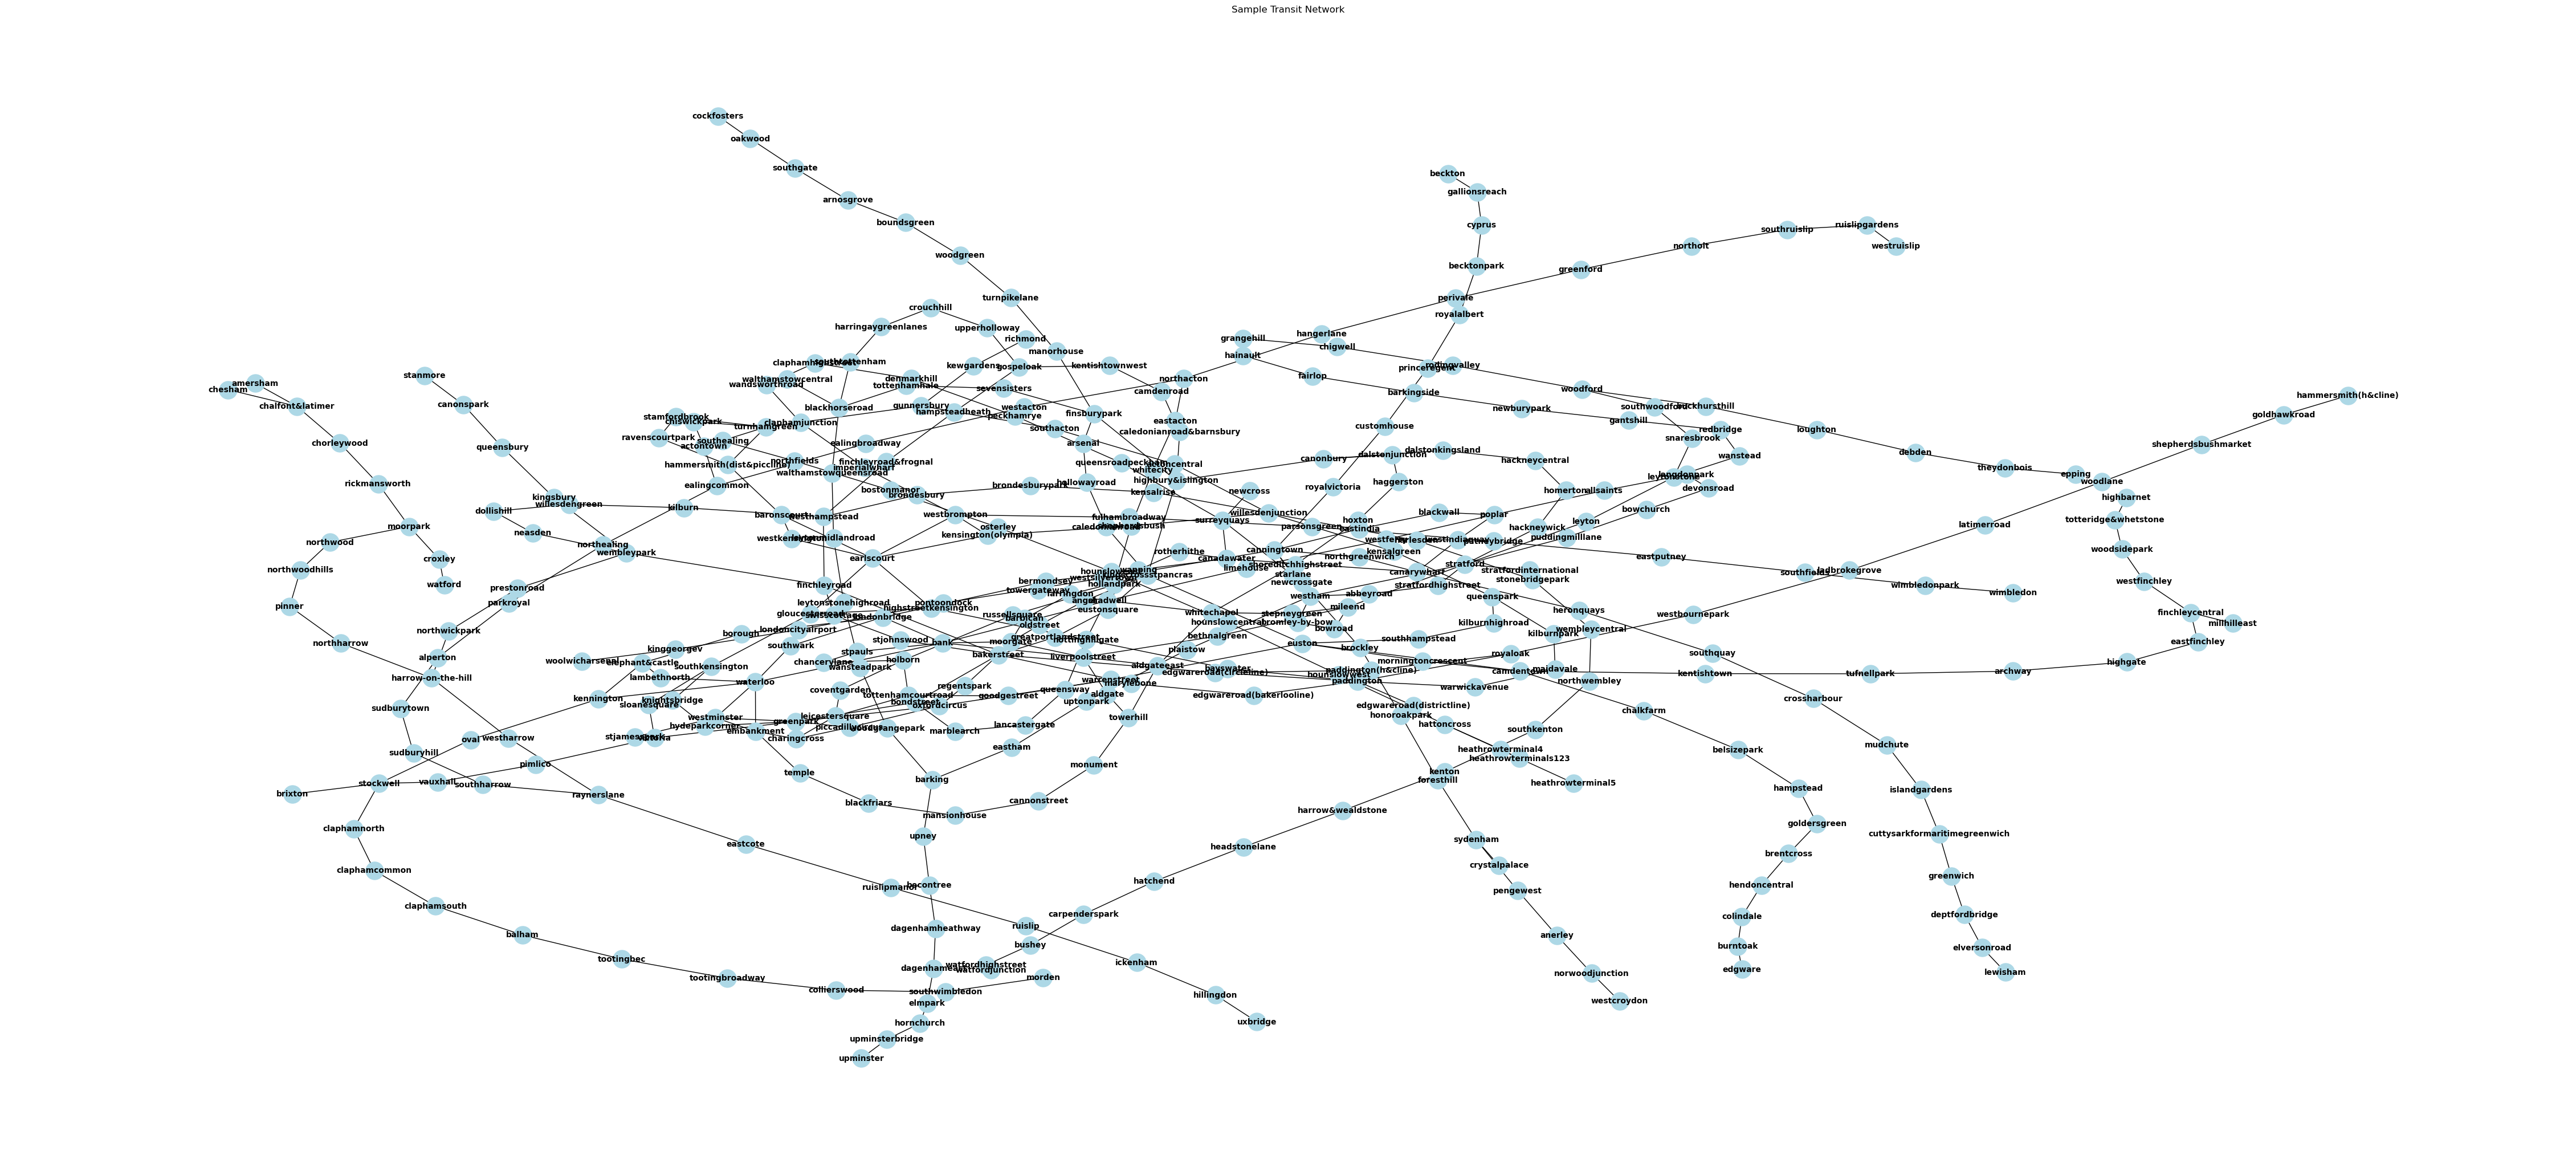

In [69]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

# Function to get top N nodes for a centrality measure
def get_top_nodes(centrality_dict, n=5):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

# Print top 5 nodes for each centrality measure
print("Top 5 nodes by Degree Centrality:", get_top_nodes(degree_centrality))
print("Top 5 nodes by Betweenness Centrality:", get_top_nodes(betweenness_centrality))
print("Top 5 nodes by Closeness Centrality:", get_top_nodes(closeness_centrality))
print("Top 5 nodes by Eigenvector Centrality:", get_top_nodes(eigenvector_centrality))
print("Top 5 nodes by PageRank:", get_top_nodes(pagerank))

# Visualize the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(45, 20))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Sample Transit Network")
plt.show()


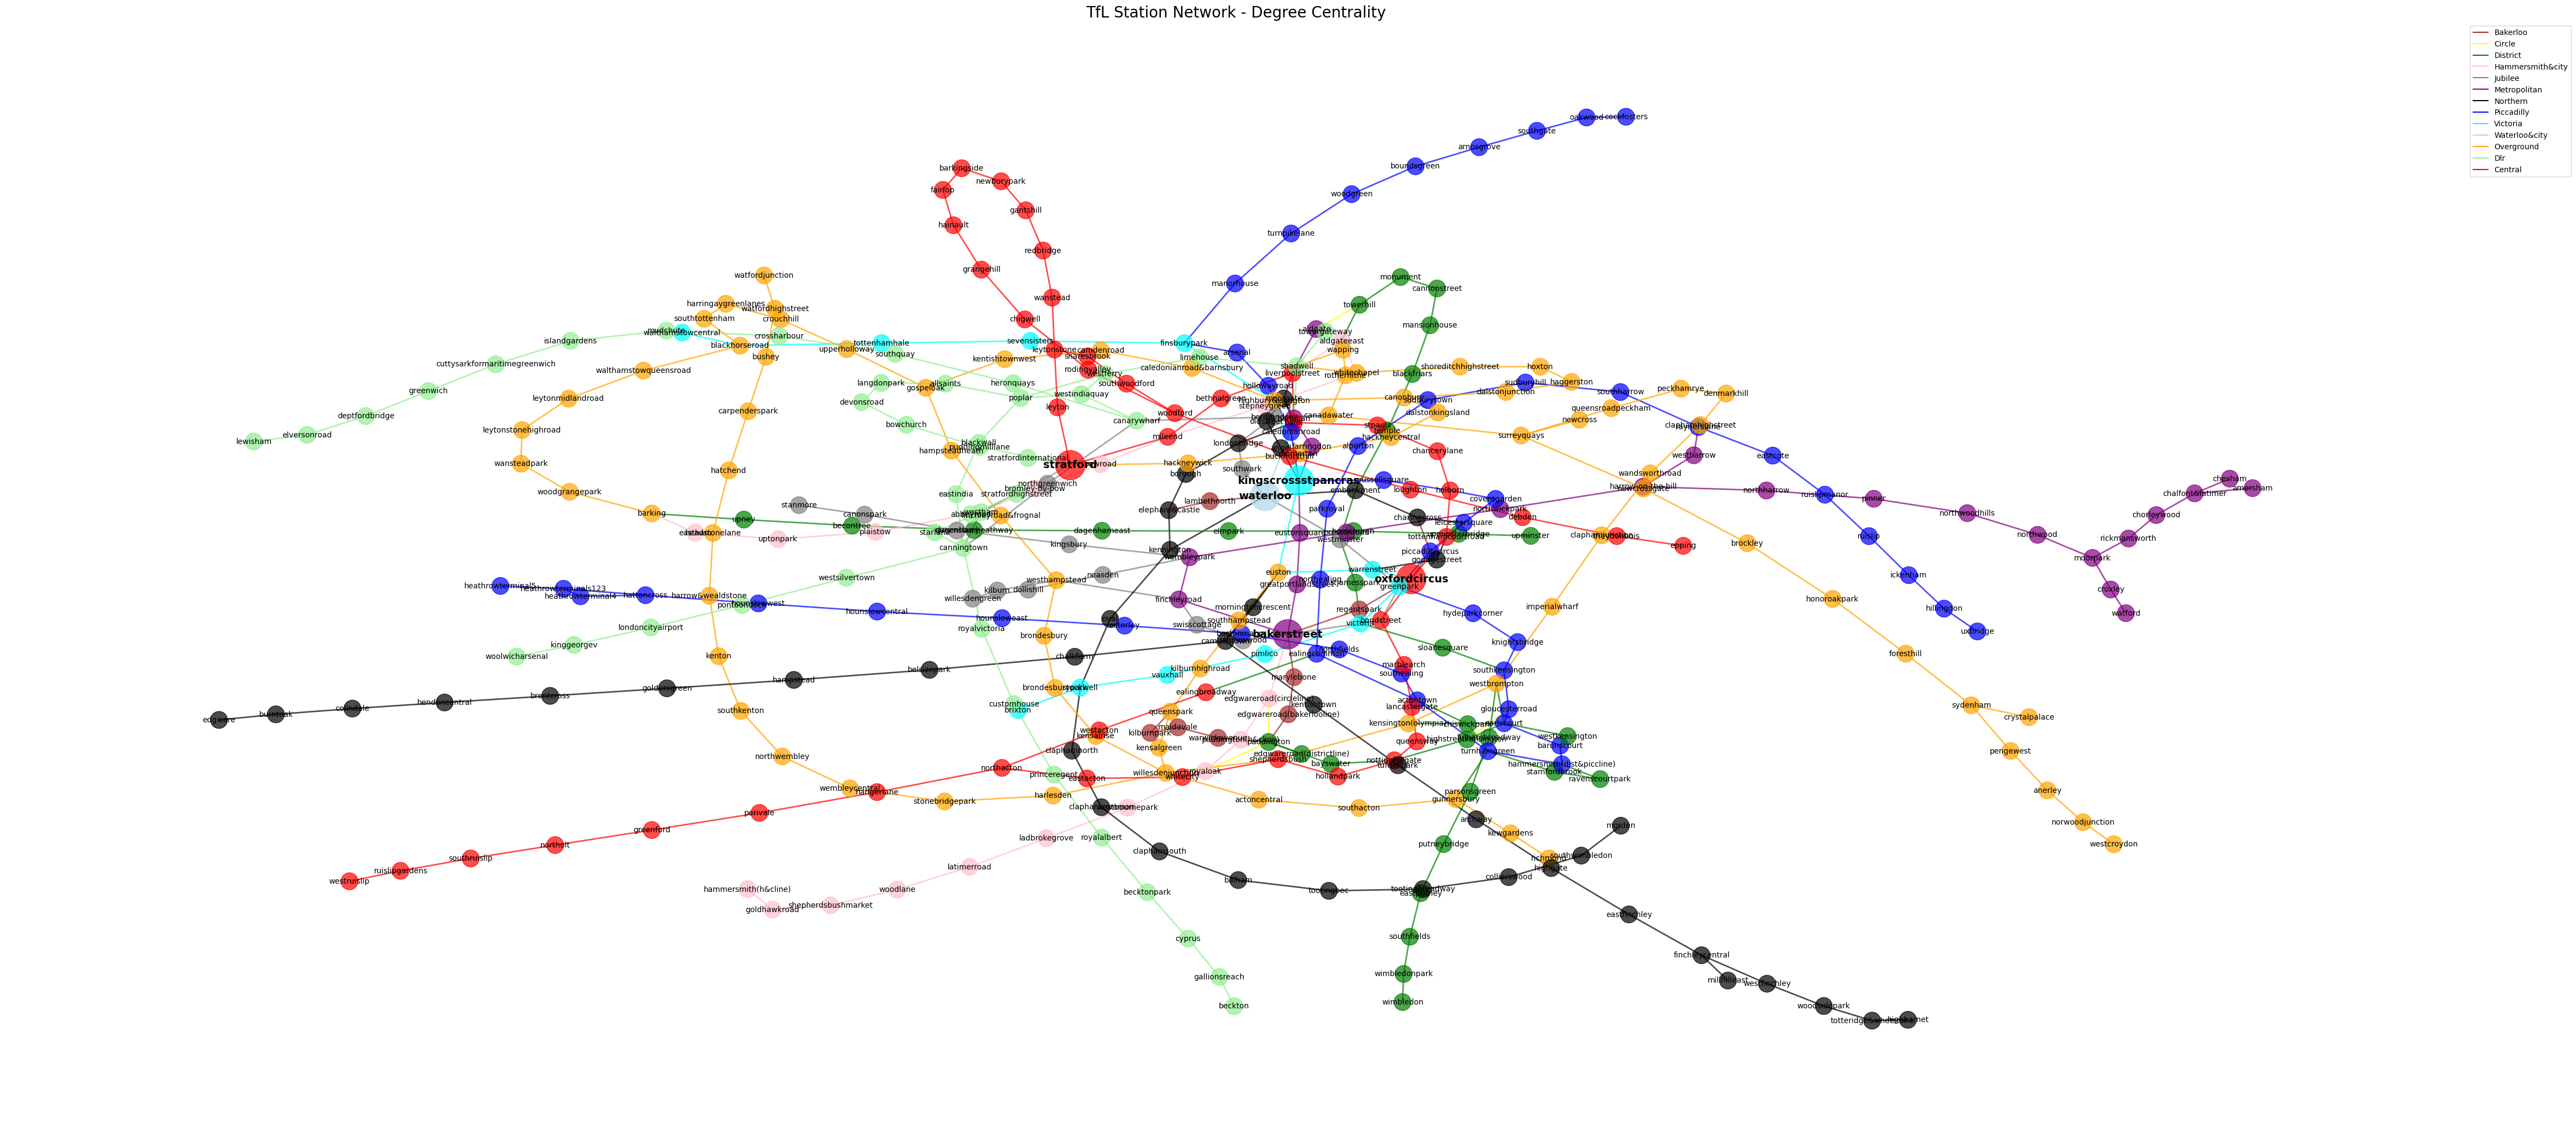

In [71]:
#calculating and plotting degree centrality of the network
degree_centrality = nx.degree_centrality(G)

# Get top 5 nodes
top_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_nodes = [node for node, _ in top_5_degree]

# Prepare node sizes
node_sizes = [1500 if node in top_5_nodes else 500 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(45, 20))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, 
        edge_color=edge_colors, width=2, alpha=0.7)

# Add labels
for node, (x, y) in pos.items():
    if node in top_5_nodes:
        plt.text(x, y, node, fontsize=14, fontweight='bold', ha='center', va='center')
    else:
        plt.text(x, y, node, fontsize=10, ha='center', va='center')

# Create custom legend for line colors
legend_patches = []
for line, color in line_colors.items():
    legend_patches.append(plt.Line2D([], [], color=color, label=line.capitalize(), linestyle='-'))
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.title('TfL Station Network - Degree Centrality', fontsize=20)
plt.show()